<a href="https://colab.research.google.com/github/DataScienceAndEngineering/deep-learning-final-project-project-sidewalk/blob/nicholas/notebooks/SAM_txtprompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Environment setup (only run once per runtime, LangSAM() may return errors otherwise)
import torch
import torchvision
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git
from PIL import Image
from lang_sam import LangSAM
model = LangSAM()
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/luca-medeiros/lang-segment-anything.git to /tmp/pip-req-build-irwwc95o
  Running command git clone --filter=blob:none --quiet https://github.com/luca-medeiros/lang-segment-anything.git /tmp/pip-req-build-irwwc95o
  Resolved https://github.com/luca-medeiros/lang-segment-anything.git to commit c60c7c4e5f2402024227853be2bb387b416b62e0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-install-ejg69qve/segment-anything_4b27e5ecc13d44eea398c81df5d336b8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-install-ejg69qve/segment-anything_4b27e5ecc13d44eea398c81df5d336b8
  Resolved https://github.com/facebookresearch/segment-anything.git t

/usr/local/lib/python3.9/dist-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


In [12]:
import os
import numpy as np
import PIL
from google.colab import drive, files
drive.mount('/content/drive')
#Uncompressing the raw data
if not os.path.isdir('/content/leftImg8bit/'):
  !unzip -n -q /content/drive/MyDrive/tensorflow_datasets/downloads/manual/leftImg8bit_trainvaltest.zip -d /content
if not os.path.isdir('/content/gtFine/'):
  !unzip -n -q /content/drive/MyDrive/tensorflow_datasets/downloads/manual/gtFine_trainvaltest.zip -d /content

## Data Extraction
def mask_2_image(path):
  # Converts the mask path string to the image path string corresponding to the same sample
  parts = path.split('/')
  parts[2] = 'leftImg8bit'
  file_name = parts[-1].split('_')
  file_name[-2] = 'leftImg8bit.png'
  file_name = file_name[0:-1]
  parts[-1] = '_'.join(file_name)
  path = '/'.join(parts)
  return path
  
def extract_files(subset='all', paths='old', download=False):
  # Returns filepaths of all labels and images which include a sidewalk segmentation
  # Additinionally, moves all valid samples into extraction folders
  if not os.path.isdir('/content/extract_labels/'):
    os.mkdir('/content/extract_labels/')
    os.mkdir('/content/extract_images/')
  labels_files = []
  img_files = []
  if subset == 'all':
    subsets = ['train', 'val', 'test']
  else:
    subsets = [subset]
  for group in subsets:
    LabelsDir = f'/content/gtFine/{group}'
    print(LabelsDir)
    for root, dirs, files_list in os.walk(LabelsDir):
      for filename in files_list:
        if filename.endswith('labelIds.png'):
          f = os.path.join(root, filename)
          labels = np.array(PIL.Image.open(f))
          if 8 in labels:
            os.rename(f, '/content/extract_labels/' + '_'.join(f.split('/')[-1].split('_')[0:3]) + '.png')
            d = mask_2_image(f)
            os.rename(d, '/content/extract_images/' + '_'.join(d.split('/')[-1].split('_')[0:3]) +'.png')
            if paths == 'old':
              labels_files.append(f)
              img_files.append(d)
            elif paths == 'new':
              f = '/content/extract_labels/' + '_'.join(f.split('/')[-1].split('_')[0:3]) + '.png'
              d = '/content/extract_images/' + '_'.join(d.split('/')[-1].split('_')[0:3]) +'.png'
              labels_files.append(f)
              img_files.append(d)
  if download:
    !zip -r /content/extracted_images.zip /content/extract_images
    !zip -r /content/extracted_labels.zip /content/extract_labels
    files.download("/content/extracted_images.zip")
    files.download("/content/extracted_labels.zip")
  return labels_files, img_files

labels_paths , image_paths = extract_files(paths='new')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/gtFine/train
/content/gtFine/val
/content/gtFine/test


In [14]:
# Isolate filenames and paths
IDs = [label.split('/')[-1] for label in labels_paths]
label_path = '/'.join(labels_paths[0].split('/')[:-1])
image_path = '/'.join(image_paths[0].split('/')[:-1])

In [15]:
#Check paths and sample ID
print(label_path)
print(image_path)
print(IDs[0])

/content/extract_labels
/content/extract_images
bochum_000000_020673.png


In [35]:
#Segmenting random sample
text_prompt = "sidewalks"
selection = random.choice(IDs)
image_pil = Image.open('/'.join([image_path, selection]))
out = model.predict(image_pil, text_prompt)

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


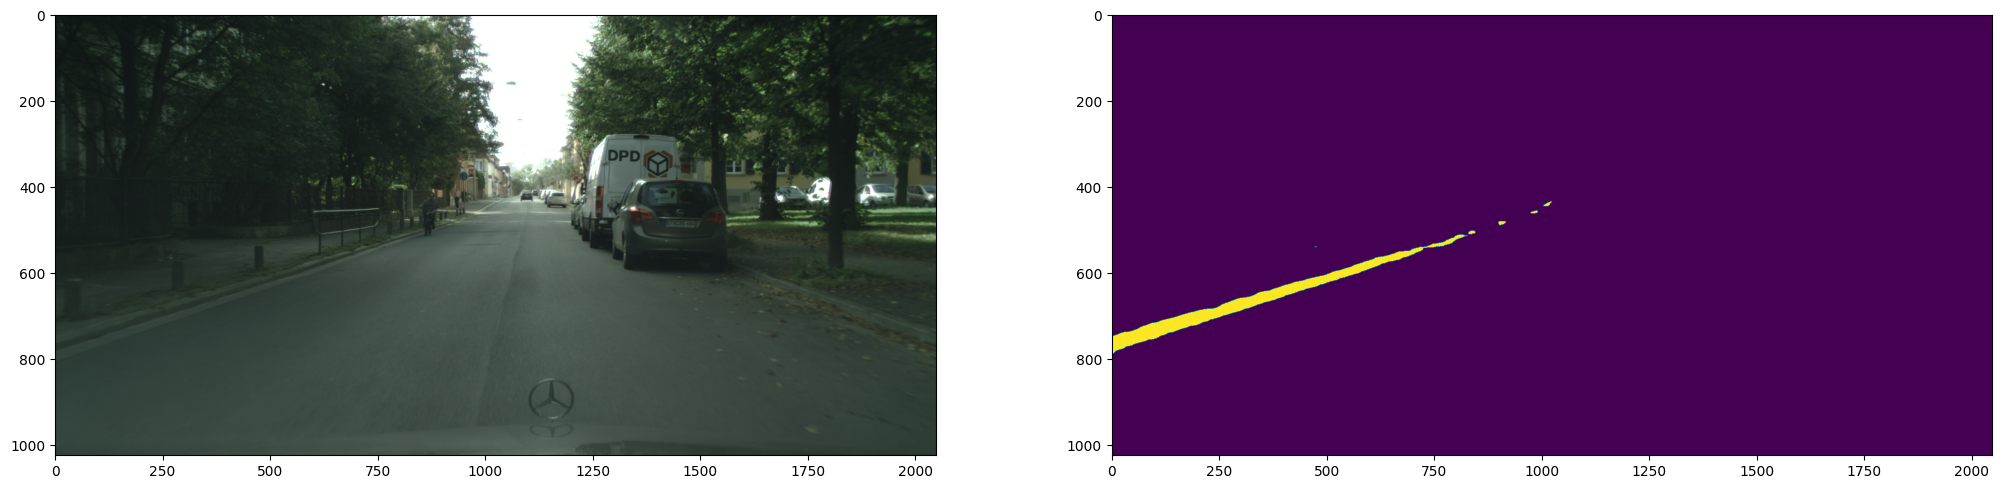

In [36]:
#Visualizing output
import matplotlib.pyplot as plt
segmentations = out[0]
if not len(segmentations) == 1:
  seg_tmp = np.zeros([image_pil.size[0], image_pil.size[1], len(segmentations)])
  i = 0
  for item in segmentations:
    seg_tmp[:,:,i] = item.numpy()[0,:,:]
    i+=1
  segmentation = np.sum(seg_tmp, axis=-1)
  segmentation = segmentation >= 1
else:
  segmentation = segmentations[0,:,:]
plt.figure(figsize=(25,50))
plt.subplot(1,2,1)
plt.imshow(image_pil)
plt.subplot(1,2,2)
plt.imshow(segmentation)
